# Descenso por gradiente en dos dimensiones

El descenso por gradiente es un algoritmo de optimización ampliamente utilizado para encontrar el mínimo local de una función diferenciable. Es especialmente fundamental en el campo del aprendizaje automático, donde se utiliza para minimizar una función de pérdida que mide el error de un modelo en función de sus parámetros.

El algoritmo se basa en el principio de que si la función es diferenciable en un punto, la dirección del gradiente en ese punto indica la dirección de mayor aumento. Por lo tanto, para encontrar un mínimo, se debe avanzar en la dirección opuesta al gradiente.

$$W_{\text{new}} = W_{\text{old}} - \eta \nabla_W \mathcal{L}$$

donde $\mathcal{L}$ es la función objetivo (función de pérdida en prendizaje), $\eta$ la tasa de aprendizaje y $W$ los parámetros de la función.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import nni

### Función objetivo: esférica

La función $f(x,y)= x^2 + y^2$ es una función matemática de dos variables que devuelve el cuadrado de la distancia euclidiana desde el origen $(0, 0)$ al punto $(x, y)$ en un plano bidimensional. Esto es, calcula la suma de los cuadrados de ambos componentes del punto.

Propiedades y características:
- No negatividad: $f(x,y) >= 0$ para todo $x,y$

- Isotropía: La función es isotrópica, lo que significa que su valor depende solo de la distancia al origen, no de la dirección. Por ejemplo, todos los puntos que están a una misma distancia del origen, sin importar su dirección, tendrán el mismo valor.

- Mínimo global: $(0, 0)$, ya que aquí $f(x,y)$ alcanza su valor mínimo de 0.

In [2]:
problem = nni.SphereProblem()

x = np.linspace(problem.min_x, problem.max_x, 100)
y = np.linspace(problem.min_y, problem.max_y, 100)

# Create a meshgrid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate the corresponding z values using the function f
Z = problem.function(X, Y)
# Applying a logarithmic transformation to Z values
Z_log = np.log(Z + 1)  # Adding 1 to avoid taking log of zero

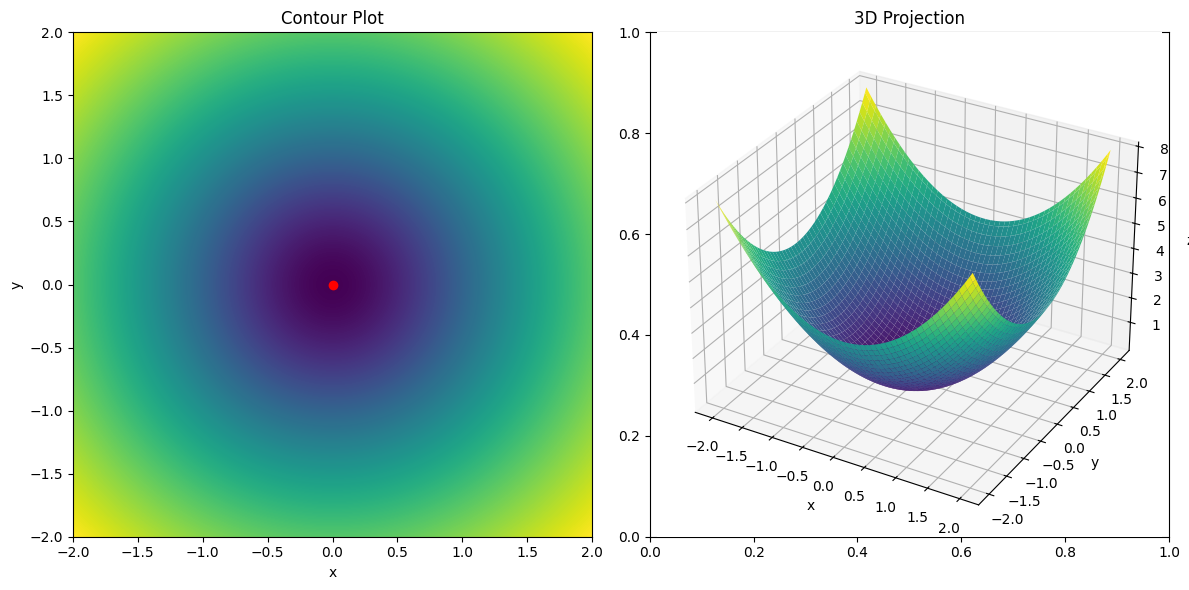

In [3]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the contour plot in the first subplot
ax1.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
ax1.plot(problem.optimal_params[0], problem.optimal_params[1], 'ro')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Contour Plot')

# Plot the 3D projection in the second subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('3D Projection')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [4]:
class Optimizer:
    def __init__(self, tolerance=1e-5):
        self.tolerance = tolerance
        self.history = []
        self.name = 'Optimizer'

class GradientDescentOptimizer(Optimizer):
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-5):
        super().__init__(tolerance=tolerance)
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.name = 'Descenso por gradiente'

    def next_params(self, gradient, params):
        return [param - self.learning_rate * grad_value for param, grad_value in zip(params, gradient)]
    
    def optimize(self, function, gradient, initial_params):
        self.history = []
        params = initial_params
        iteration = 0

        while iteration < self.max_iterations:
            log = {'iter': iteration, 'params': params, 'value': function(*params)}
            self.history.append(log)

            gradient_values = gradient(*params)
            updated_params = self.next_params(gradient_values, params)
            if self._converged(params, updated_params):
                break
            params = updated_params
            iteration += 1
        return params
    
    def _converged(self, params, updated_params):
        return all(abs(param - updated_param) < self.tolerance for param, updated_param in zip(params, updated_params))
    
    def get_history(self):
        return self.history
    

In [20]:
# -- hyperparameters --
# Initial guess
problem.set_initial_params([-1.0, -1.0])
# Learning rate
learning_rate = 0.1
# Maximum number of iterations
max_iterations = 250

In [21]:
optimizer = GradientDescentOptimizer(learning_rate=learning_rate, max_iterations=max_iterations, tolerance=1e-6)

# Optimize the function
optimized_params = optimizer.optimize(problem.function, lambda x, y: [problem.gradient_x(x, y), problem.gradient_y(x, y)], problem.initial_params)

print(f'Parámetros optimizados: {optimized_params}')
print(f'Mejor valor encontrado: {problem.function(*optimized_params)}')

Parámetros optimizados: [-4.676805239458891e-06, -4.676805239458891e-06]
Mejor valor encontrado: 4.3745014495660267e-11


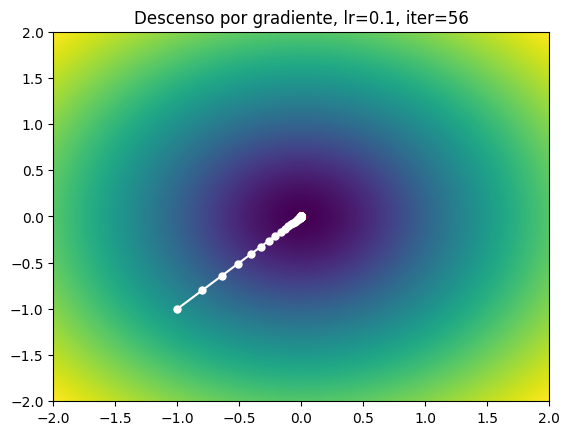

In [22]:
# Extract the x and y values from the history variable
history = optimizer.get_history()
x_values = [log['params'][0] for log in history]
y_values = [log['params'][1] for log in history]

# Create a 2D plot of the function
plt.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
plt.plot(problem.optimal_params[0], problem.optimal_params[1], 'ro')
plt.plot(x_values, y_values, 'w.-', markersize=10)
plt.title(f'{optimizer.name}, lr={optimizer.learning_rate}, iter={len(history)}')
plt.show()

In [ ]:
#Animate and save the optimization process
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
points = ax.scatter(x_values[0], y_values[0], c='w', s=10)

# Function to update the plot for each frame
def update(frame):
    # Clear the previous plot
    ax.cla()
    
    # Create a new contour plot
    contour = ax.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
    plt.plot(problem.optimal_params[0], problem.optimal_params[1], 'ro')
    if frame > 0:
        # Plot the optimization path
        points = ax.plot(x_values[:frame], y_values[:frame], 'w.-', markersize=10)
    else:
        points = ax.scatter(x_values[:frame], y_values[:frame], c='w', s=10)
    # Update the title for each frame
    ax.set_title(f'{optimizer.name} lr = {optimizer.learning_rate}, iter {frame}/{len(x_values)}')

    return (contour, points)
    
# Create the animation
animation.FuncAnimation(fig, update, frames=len(x_values), interval=30).save('gradient_descent.mp4')
